<a href="https://colab.research.google.com/github/Venchislav/Neural-Networks/blob/main/GAN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import mnist
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D, LeakyReLU, Dropout, Reshape
from keras.models import Model, Sequential
from keras.optimizers import Adam

In [2]:
(X_train, _), (X_test, _) = mnist.load_data()

# concatenating X_train and X_test (as we don't give a sh😧t)
X = np.vstack((X_train, X_test))
X = X.astype('float32')
X = (X - 127.5) / 127.5

11490434/11490434 [==============================] - 0s 0us/step


In [3]:
X.shape

(70000, 28, 28)

In [4]:
def build_generator(n):
  input = Input(shape=(n,))

  x = Dense(256, activation=LeakyReLU(alpha=0.1))(input)
  x = Dense(512, activation=LeakyReLU(alpha=0.1))(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(784, activation='tanh')(x)

  output = Reshape((28, 28, 1))(x)

  return Model(input, output)

In [5]:
def build_discriminator():
  input = Input(shape=(28, 28, 1))

  x = Flatten()(input)
  x = Dropout(0.4)(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = Dropout(0.4)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = Dropout(0.4)(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)

  output = Dense(1, activation='sigmoid')(x)
  model = Model(input, output)
  model.compile(
      optimizer=Adam(),
      loss='binary_crossentropy'
      )
  return model

In [6]:
def gan(gen, disc):
  disc.trainable = False

  model = Sequential([
      gen,
      disc
  ])

  model.compile(
      optimizer=Adam(lr=0.001),
      loss='binary_crossentropy'
  )

  return model

In [7]:
discriminator = build_discriminator()

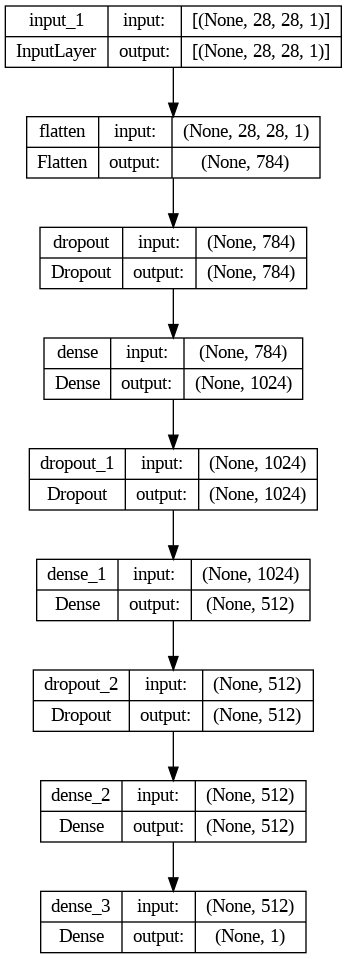

In [8]:
keras.utils.plot_model(discriminator, show_shapes=True)

In [9]:
generator = build_generator(100)

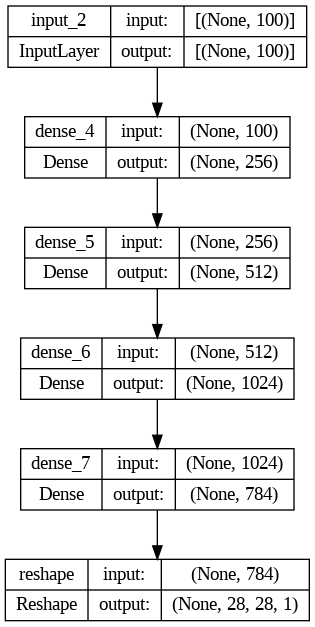

In [10]:
keras.utils.plot_model(generator, show_shapes=True)

In [11]:
gan_model = gan(generator, discriminator)

1/1 [==============================] - 0s 344ms/step


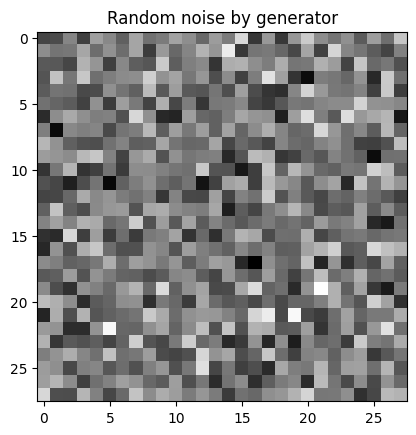

In [12]:
plt.title('Random noise by generator')
plt.imshow(generator.predict(np.random.randn(100).reshape(1, 100))[0], cmap='gray');

1/1 [==============================] - 0s 184ms/step


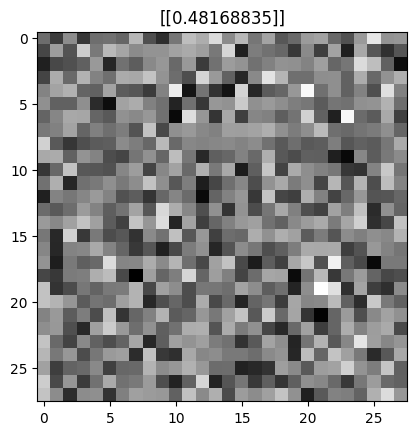

In [13]:
gen_pred = generator.predict(np.random.randn(100).reshape(1, 100)).reshape(28, 28, 1)
plt.title(discriminator.predict(gen_pred.reshape(1, 28, 28, 1)))
plt.imshow(gen_pred, cmap='gray');

In [14]:
from tqdm import tqdm

In [15]:
epochs = 100
batch_size = 256
half_batch = batch_size // 2
n = 100
losses = []

epoch 0 ---- losses[d/g]: [3.8084601783339167e-06, 45.44074249267578]
epoch 1 ---- losses[d/g]: [2.27546524911304e-06, 37.66368103027344]
epoch 2 ---- losses[d/g]: [1.4523971003654879e-06, 75.08857727050781]
epoch 3 ---- losses[d/g]: [1.0279504749632906e-06, 73.6916275024414]
epoch 4 ---- losses[d/g]: [1.2639525266422424e-06, 76.23123168945312]
epoch 5 ---- losses[d/g]: [1.8505520529288333e-06, 74.8875503540039]
epoch 6 ---- losses[d/g]: [2.3632505019577366e-07, 66.91929626464844]
epoch 7 ---- losses[d/g]: [1.575270403009199e-07, 72.5115966796875]
epoch 8 ---- losses[d/g]: [1.5444132372977037e-07, 72.61936950683594]
epoch 9 ---- losses[d/g]: [1.7219505821230996e-07, 76.14300537109375]
epoch 10 ---- losses[d/g]: [1.5727290758604795e-07, 73.86077880859375]
epoch 11 ---- losses[d/g]: [2.894810791076452e-07, 74.74130249023438]
epoch 12 ---- losses[d/g]: [1.8344283603255462e-07, 74.60820770263672]
epoch 13 ---- losses[d/g]: [9.307345294473635e-08, 75.81309509277344]
epoch 14 ---- losses[d/g

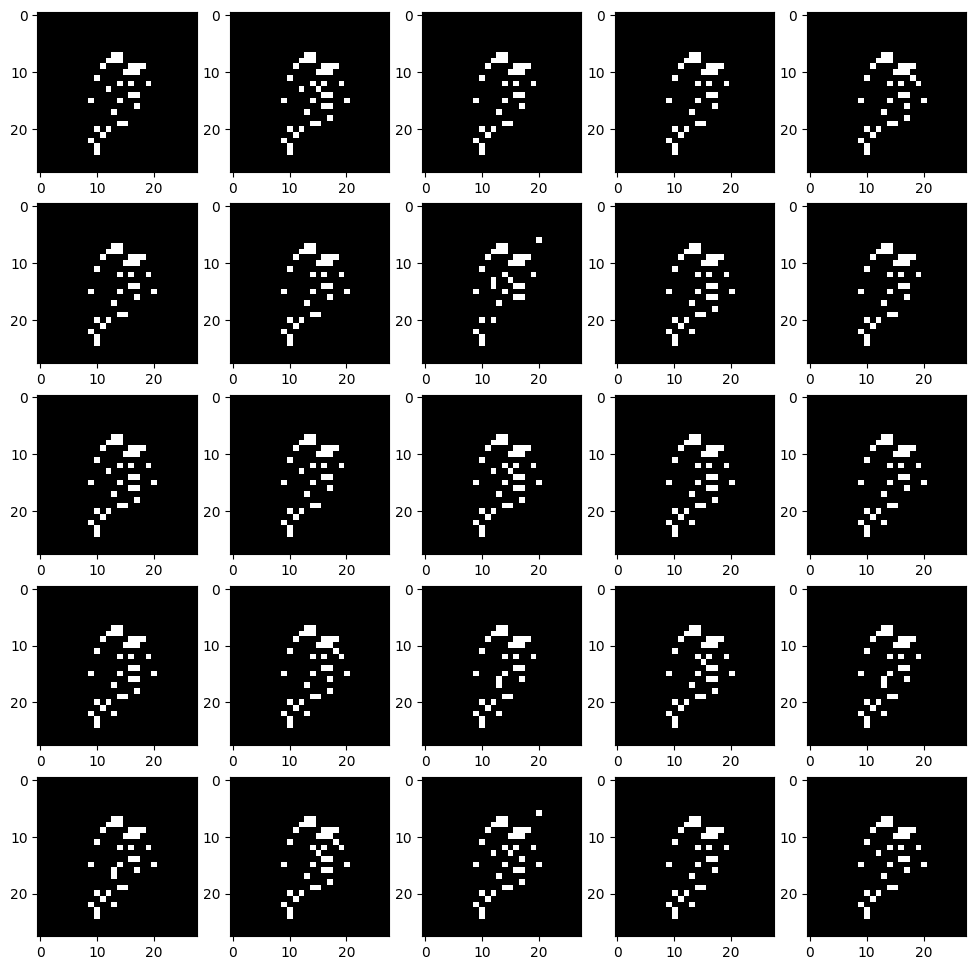

In [16]:
for i in range(epochs):
  for j in range(len(X)//batch_size):
    X_real = X[np.random.randint(0, len(X), half_batch)].reshape(half_batch, 28, 28, 1)
    y_real = np.ones(half_batch).reshape(half_batch, 1)

    X_fake = generator.predict(np.random.randn(half_batch, n), verbose=0)
    y_fake = np.zeros(half_batch).reshape(half_batch, 1)

    X_final = np.vstack((X_real, X_fake))
    y_final = np.vstack((y_real, y_fake))

    dloss = discriminator.train_on_batch(X_final, y_final)
    gloss = gan_model.train_on_batch(np.random.randn(batch_size, n), np.ones(batch_size).reshape(batch_size, 1))

    losses.append([dloss, gloss])
  print(f'epoch {i} ---- losses[d/g]: {losses[-1]}')

ip, axes = plt.subplots(5, 5, figsize=(12, 12))
for ii in range(5):
  for jj in range(5):
    axes[ii, jj].imshow(generator.predict(np.random.randn(n).reshape(1, n), verbose=0).reshape(28, 28, 1), cmap='gray')

plt.show();

I guess it's seven, but here's a Very VERY VEEERY big problem of GANs.<br>
They are very heavy. I've been conected to the CoLab GPU and these 100 epochs took 2 episodes of "The Boys" series (2 hours). And after all: results are shitty. The only way to deal with GANs is: <br>
Train your model whole night (but I love my pc, so I don't want to do that) or rent a server (like AWS or other), but I'm bum and I don't want to do that.<br>
So, it's kinda painful... I'll try my best to apply GANs on my ConvMoNET Project. I'll try...